In [1]:
import os
import sys

In [2]:
os.chdir('/home/au643300/DataHandling/')
sys.path.append('/home/au643300/DataHandling/')

In [3]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, as_completed
import glob
from src.data.tonetCDF import to_netcdf
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from src.interim import read_valdata
import numpy as np

In [4]:
sns.set_theme()

In [5]:
cluster=SLURMCluster(cores=6,
                     processes=1,
                     memory="22GiB",
                     queue='q64',
                     walltime='0-00:30:00',
                     local_directory='/scratch/$SLURM_JOB_ID',
                     interface='ib0',
                     extra=['--resources mem=15']
                    )
                    

In [6]:
client=Client(cluster)

In [7]:
cluster.adapt(minimum_jobs=1,maximum_jobs=3)

In [8]:
client

Client Scheduler: tcp://10.100.8.11:36649 Dashboard: http://10.100.8.11:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
ds=xr.open_mfdataset("/home/au643300/NOBACKUP/test/*nc",chunks=1000,parallel=True,combine='nested',concat_dim='time')

In [10]:
ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 256, y: 201, z: 256)
Coordinates:
  * x        (x) float64 0.0 0.04688 0.09375 0.1406 ... 11.81 11.86 11.91 11.95
  * y        (y) float64 2.0 2.0 2.0 1.999 ... 0.00111 0.0004934 0.0001234 0.0
  * z        (z) float64 -3.0 -2.977 -2.953 -2.93 ... 2.906 2.93 2.953 2.977
  * time     (time) float64 2.024e+03 2.028e+03 2.032e+03 2.036e+03
Data variables:
    u_vel    (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    v_vel    (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    w_vel    (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr1      (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr0.71   (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr0.2    (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr0.025  (time, x, y, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>

Constants from the simulation

In [11]:
Re_Tau = 395 #Direct from simulation
Re = 10400 #Direct from simulation
nu = 1/Re #Kinematic viscosity
u_tau = Re_Tau*nu #The friction velocity 
#y_plus=(y*utau/nu)


changes y til y+. goes from 790 to 0. so y_plus[0]=790

In [12]:
ds=ds.assign_coords(y=(ds.y*u_tau/nu))
ds=ds.rename({'y':'y_plus'})
ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 256, y_plus: 201, z: 256)
Coordinates:
  * x        (x) float64 0.0 0.04688 0.09375 0.1406 ... 11.81 11.86 11.91 11.95
  * y_plus   (y_plus) float64 790.0 790.0 789.8 789.6 ... 0.1949 0.04873 0.0
  * z        (z) float64 -3.0 -2.977 -2.953 -2.93 ... 2.906 2.93 2.953 2.977
  * time     (time) float64 2.024e+03 2.028e+03 2.032e+03 2.036e+03
Data variables:
    u_vel    (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    v_vel    (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    w_vel    (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr1      (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr0.71   (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr0.2    (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>
    pr0.025  (time, x, y_plus, z) float64 dask.array<chunksize=(1, 256, 201, 256), meta=np.ndarray>

First the computations are made for the velocities

In [13]:
#mean_try=ds.mean(dim=['x','z','time'])
#stats=xr.Dataset.mean(ds,dim=['x','z'])
mean=ds


In [14]:
ds.u_vel

<xarray.DataArray 'u_vel' (time: 4, x: 256, y_plus: 201, z: 256)>
dask.array<concatenate, shape=(4, 256, 201, 256), dtype=float64, chunksize=(1, 256, 201, 256), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.04688 0.09375 0.1406 ... 11.81 11.86 11.91 11.95
  * y_plus   (y_plus) float64 790.0 790.0 789.8 789.6 ... 0.1949 0.04873 0.0
  * z        (z) float64 -3.0 -2.977 -2.953 -2.93 ... 2.906 2.93 2.953 2.977
  * time     (time) float64 2.024e+03 2.028e+03 2.032e+03 2.036e+03

Kører over alle de forskellige variable i datasettet. Skifter mellem skalaerer ved k=3

In [15]:
val_list=list(ds.keys())
mean=ds
mean=mean.drop(labels=val_list)
k=0
for val in val_list:
    mean_tem=ds[val]/u_tau
    mean_tem=xr.DataArray.mean(mean_tem,dim=('x','z'))
    rms_tem=xr.ufuncs.sqrt(((ds[val]/u_tau)-mean_tem)**2)
    rms_tem=xr.DataArray.mean(rms_tem,dim=('x','z'))
    mean[val[0]+'_plusmean']=mean_tem
    mean[val[0]+'_plusRMS']=rms_tem
    if k>2: #So for the Pr numbers
        mean=mean.drop(labels=val[0]+'_plusmean')
        mean=mean.drop(labels=val[0]+'_plusRMS')
        pr=float(val[2:])
        theta_tau=(mean_tem[:,1]*mean_tem[:,0])/((mean_tem.y_plus[0]-mean_tem.y_plus[1])*pr)
        theta_plus=mean_tem/theta_tau
        rms_pr=rms_tem/theta_tau
        mean[val+'_plusmean']=theta_plus
        mean[val+'_plusRMS']=rms_pr
    k=k+1
    


Samler alt her i bins. Her pt sat til 2 lige store bins

In [16]:
batches=2

In [17]:
mean=mean.groupby_bins('time',batches).mean(dim='time')
mean

<xarray.Dataset>
Dimensions:           (time_bins: 2, x: 256, y_plus: 201, z: 256)
Coordinates:
  * time_bins         (time_bins) object (2023.988, 2030.0] (2030.0, 2036.0]
  * x                 (x) float64 0.0 0.04688 0.09375 ... 11.86 11.91 11.95
  * y_plus            (y_plus) float64 790.0 790.0 789.8 ... 0.1949 0.04873 0.0
  * z                 (z) float64 -3.0 -2.977 -2.953 -2.93 ... 2.93 2.953 2.977
Data variables: (12/14)
    u_plusmean        (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    u_plusRMS         (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    v_plusmean        (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    v_plusRMS         (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    w_plusmean        (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    w_plusRMS         (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    ...                ...
    pr0.71_plusmean   (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.71_plusRMS    (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.2_plusmean    (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.2_plusRMS     (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.025_plusmean  (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.025_plusRMS   (time_bins, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>

# Time for Plots

first for u

In [18]:
val_u=read_valdata.get_valdata('u')
val_u

,y+,u_plusmean,u_plusRMS
0,0.110599,0.111710,0.044552
1,0.335591,0.338835,0.134803
2,0.568392,0.573689,0.227932
3,0.809442,0.816661,0.324119
4,1.059180,1.068110,0.423493
...,...,...,...
235,385.400000,20.388000,0.811675
236,387.534000,20.389900,0.810588
237,389.667000,20.391200,0.809762
238,391.800000,20.392100,0.809203


Here $<u_+>$ and $<u_{rms}>$ are plotted

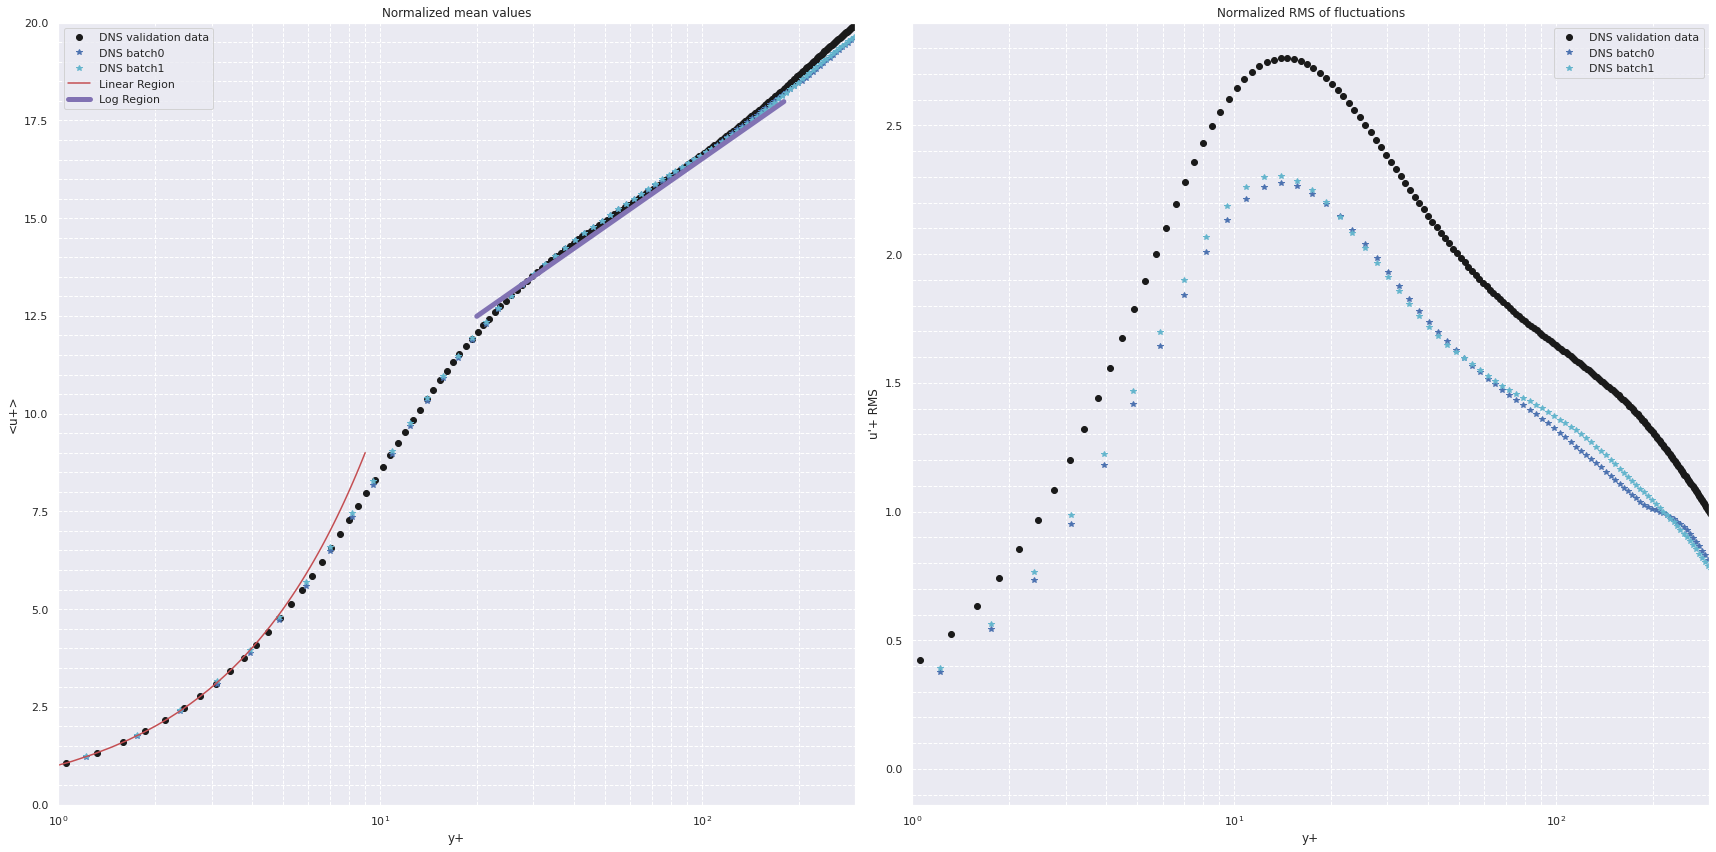

In [20]:
linerRegion = np.linspace(0,9)
logRegion = 1/0.4*np.log(np.linspace(20, 180))+5
figScale=2
fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(12*figScale,6*figScale))
ax1.plot('y+', 'u_plusmean','ok',data=val_u, label='DNS validation data')
colorList = ['*b', '*c', '*y', '*g','.b', '.c', '.y', '.g','vb', 'vc', 'vy', 'vg','<b', '<c', '<y', '<g']*30
#Plotting the batches in mean for U
for i in range(len(mean.time_bins)):
    ax1.plot(mean.y_plus, mean.u_plusmean.isel(time_bins=i), colorList[i], label='DNS batch'+str(i))
    
ax1.plot(linerRegion, linerRegion, 'r', label='Linear Region')
ax1.plot(np.linspace(20,180), logRegion, 'm', linewidth=5, label='Log Region')  

ax1.set_title('Normalized mean values')
ax1.set_xscale('log')
ax1.set_xlabel('y+')
ax1.set_ylabel('<u+>')
ax1.set_xlim(1,300)
ax1.set_ylim(0,20)
ax1.minorticks_on()
ax1.grid(True,which="both", linestyle='--')
ax1.legend()

#Now for <u_rms>

ax2.plot('y+', 'u_plusRMS','ok',data=val_u, label='DNS validation data')
ax2.set_title('Normalized RMS of fluctuations')
for i in range(len(mean.time_bins)):
        ax2.plot(mean.y_plus, mean.u_plusRMS.isel(time_bins=i), colorList[i], label='DNS batch'+str(i))

ax2.set_xscale('log')
ax2.set_xlabel('y+')
ax2.set_ylabel("u'+ RMS")
ax2.set_xlim(1,300)
ax2.minorticks_on()
ax2.grid(True,which="both", linestyle='--')
ax2.legend()
plt.tight_layout()

<xarray.DataArray 'u_plusRMS' ()>
array(20.0747801)
Coordinates:
    time_bins  object (2023.988, 2030.0]
    y_plus     float64 395.0